In [1]:
import math
from typing import Optional, Tuple, Dict, List, Any
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset
from torch.utils.data import Subset
import torchvision
from torchvision import datasets
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm
import random
from torch.utils.data import Dataset


In [2]:
def _flatten_hw(x: torch.Tensor) -> torch.Tensor:
    # [B,C,H,W] -> [B,HW,C]
    return x.flatten(2).transpose(1, 2).contiguous()


def _resize_mask_to(mask: torch.Tensor, size_hw: Tuple[int, int]) -> torch.Tensor:
    # mask: [B,1,H,W] float/bool -> [B,1,h,w] float
    if mask.dtype != torch.float32:
        mask = mask.float()
    return F.interpolate(mask, size=size_hw, mode="nearest")


def gather_tokens_from_mask_fixed(
    x: torch.Tensor,               # [B,C,H,W]
    mask: torch.Tensor,            # [B,1,H,W] or [B,H,W]
    max_tokens: int,
    ensure_nonempty: bool = True,
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Returns:
      T:    [B, max_tokens, C]
      Tpad: [B, max_tokens] True=PAD
    """
    if mask.dim() == 4:
        mask = mask[:, 0]
    B, C, H, W = x.shape
    x_flat = _flatten_hw(x)               # [B,HW,C]
    m_flat = mask.flatten(1).bool()       # [B,HW]

    T = x.new_zeros((B, max_tokens, C))
    Tpad = torch.ones((B, max_tokens), device=x.device, dtype=torch.bool)

    for b in range(B):
        idx = torch.where(m_flat[b])[0]
        if idx.numel() == 0 and ensure_nonempty:
            idx = torch.arange(H * W, device=x.device)
        if idx.numel() > max_tokens:
            idx = idx[torch.randperm(idx.numel(), device=x.device)[:max_tokens]]
        n = idx.numel()
        if n > 0:
            T[b, :n] = x_flat[b, idx]
            Tpad[b, :n] = False
    return T, Tpad


def gather_fg_variable_tokens(
    x: torch.Tensor,               # [B,C,H,W] or [B,3,H,W]
    fg_mask: torch.Tensor,         # [B,1,H,W] or [B,H,W]
    max_tokens: Optional[int] = None,
    ensure_nonempty: bool = True,
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Variable-length gather then pad to batch max.
    Returns:
      T:    [B,Lmax,C]
      Tpad: [B,Lmax] True=PAD
    """
    if fg_mask.dim() == 4:
        fg_mask = fg_mask[:, 0]
    B, C, H, W = x.shape
    x_flat = _flatten_hw(x)               # [B,HW,C]
    m_flat = fg_mask.flatten(1).bool()    # [B,HW]

    toks, lens = [], []
    for b in range(B):
        idx = torch.where(m_flat[b])[0]
        if idx.numel() == 0 and ensure_nonempty:
            idx = torch.arange(H * W, device=x.device)
        if max_tokens is not None and idx.numel() > max_tokens:
            idx = idx[torch.randperm(idx.numel(), device=x.device)[:max_tokens]]
        tok = x_flat[b, idx]              # [N,C]
        toks.append(tok)
        lens.append(tok.shape[0])

    Lmax = max(lens) if lens else 1
    T = x.new_zeros((B, Lmax, C))
    Tpad = torch.ones((B, Lmax), device=x.device, dtype=torch.bool)
    for b, tok in enumerate(toks):
        n = tok.shape[0]
        if n > 0:
            T[b, :n] = tok
            Tpad[b, :n] = False
    return T, Tpad


def build_S_QP_from_support(
    f_s: torch.Tensor,         # [B,K,C,Hf,Wf]
    y_s: torch.Tensor,         # [B,K,1,H,W] (support masks)
    max_support_tokens: int = 1024,
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Build S_QP tokens by taking all support foreground pixels (across K shots) and padding.

    Returns:
      S_QP:     [B, Ls, C]
      S_QP_pad: [B, Ls] True=PAD
    """
    B, K, C, Hf, Wf = f_s.shape
    # resize masks to feature resolution
    y_s_rs = _resize_mask_to(y_s.view(B * K, 1, *y_s.shape[-2:]), (Hf, Wf)).view(B, K, 1, Hf, Wf)

    # per-sample concatenate variable-length tokens across shots, then pad
    all_tokens = []
    lens = []
    f_s_flat = f_s.flatten(3).transpose(2, 3).contiguous()  # [B,K,HW,C]
    y_flat = y_s_rs[:, :, 0].flatten(2).bool()              # [B,K,HW]

    for b in range(B):
        toks_b = []
        for k in range(K):
            idx = torch.where(y_flat[b, k])[0]
            if idx.numel() == 0:
                # fallback: if empty fg, just take all pixels
                idx = torch.arange(Hf * Wf, device=f_s.device)
            tok = f_s_flat[b, k, idx]  # [Nk,C]
            toks_b.append(tok)
        tok_cat = torch.cat(toks_b, dim=0) if len(toks_b) else f_s.new_zeros((1, C))

        # cap total tokens
        if tok_cat.shape[0] > max_support_tokens:
            sel = torch.randperm(tok_cat.shape[0], device=f_s.device)[:max_support_tokens]
            tok_cat = tok_cat[sel]

        all_tokens.append(tok_cat)
        lens.append(tok_cat.shape[0])

    Ls = max(lens) if lens else 1
    S_QP = f_s.new_zeros((B, Ls, C))
    S_QP_pad = torch.ones((B, Ls), device=f_s.device, dtype=torch.bool)
    for b, tok in enumerate(all_tokens):
        n = tok.shape[0]
        S_QP[b, :n] = tok
        S_QP_pad[b, :n] = False
    return S_QP, S_QP_pad

In [3]:
class QueryPrediction(nn.Module):
    """
    P = phi_p( CAT( AVG(S_QP), f_q ) )
    """
    def __init__(self, C: int, num_classes: int = 2):
        super().__init__()
        self.phi_p = nn.Sequential(
            nn.Conv2d(2 * C, C, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(C, num_classes, 1),
        )

    def forward(self, S_QP: torch.Tensor, f_q: torch.Tensor, S_QP_pad: Optional[torch.Tensor] = None) -> torch.Tensor:
        # masked mean if pad provided
        if S_QP_pad is None:
            s_qp = S_QP.mean(dim=1)  # [B,C]
        else:
            keep = (~S_QP_pad).float().unsqueeze(-1)          # [B,L,1]
            denom = keep.sum(dim=1).clamp_min(1.0)
            s_qp = (S_QP * keep).sum(dim=1) / denom           # [B,C]

        B, C, H, W = f_q.shape
        s_qp = s_qp.view(B, C, 1, 1).expand(B, C, H, W)
        x = torch.cat([s_qp, f_q], dim=1)
        P = self.phi_p(x)                                     # [B,2,H,W]
        return P


In [4]:
class SoftHistogram(nn.Module):
    """Triangular (spire-like) soft binning over [0,1]."""
    def __init__(self, L: int = 16):
        super().__init__()
        self.L = L
        edges = torch.linspace(0.0, 1.0, L + 1)
        centers = 0.5 * (edges[:-1] + edges[1:])
        self.register_buffer("centers", centers)  # [L]
        self.width = 1.0 / L

    def forward(self, a: torch.Tensor) -> torch.Tensor:
        a = a.clamp(0.0, 1.0).unsqueeze(-1)        # [N,1]
        c = self.centers.unsqueeze(0)              # [1,L]
        w = self.width
        wts = (1.0 - (a - c).abs() / w).clamp_min(0.0)  # [N,L]
        return wts.sum(dim=0)                           # [L]


class EvolutionFeature(nn.Module):
    """
    Inputs: I_q, f_q, P -> Outputs: E tokens [B,Nf,C] + E_pad
    """
    def __init__(self, C: int, L: int = 16, max_fg_tokens: int = 512, max_pairs: int = 8192):
        super().__init__()
        self.C = C
        self.L = L
        self.max_fg_tokens = max_fg_tokens
        self.max_pairs = max_pairs

        self.conv_I = nn.Conv2d(3, C, 1)   # I_q -> F_I
        self.conv_O = nn.Conv2d(C, C, 1)   # f_q -> F_O

        self.mlp_Ep = nn.Sequential(
            nn.Linear(2 * C, C),
            nn.ReLU(inplace=True),
            nn.Linear(C, C),
        )

        self.hist = SoftHistogram(L)
        self.mlp_Es = nn.Sequential(
            nn.Linear(2 * L, C),
            nn.ReLU(inplace=True),
            nn.Linear(C, C),
        )

    def forward(self, I_q: torch.Tensor, f_q: torch.Tensor, P: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        B, C, H, W = f_q.shape
        pred = P.argmax(dim=1, keepdim=True)      # [B,1,H,W]
        fg_mask = (pred == 1).float()

        I_q_rs = F.interpolate(I_q, size=(H, W), mode="bilinear", align_corners=False)

        # ---- E_p
        F_I = self.conv_I(I_q_rs)
        F_O = self.conv_O(f_q)

        F_I_tok, E_pad = gather_fg_variable_tokens(F_I, fg_mask, max_tokens=self.max_fg_tokens)
        F_O_tok, _     = gather_fg_variable_tokens(F_O, fg_mask, max_tokens=self.max_fg_tokens)

        E_p = self.mlp_Ep(torch.cat([F_I_tok, F_O_tok], dim=-1))  # [B,Nf,C]

        # ---- E_s
        T_I, TI_pad = gather_fg_variable_tokens(I_q_rs, fg_mask, max_tokens=self.max_fg_tokens)  # [B,Nf,3]
        T_O, _      = gather_fg_variable_tokens(f_q,    fg_mask, max_tokens=self.max_fg_tokens)  # [B,Nf,C]

        Es_list = []
        for b in range(B):
            keep = ~TI_pad[b]
            ti = T_I[b, keep]
            to = T_O[b, keep]
            if ti.numel() == 0 or to.numel() == 0:
                Es_list.append(f_q.new_zeros((C,)))
                continue

            ti_n = F.normalize(ti, dim=1)
            to_n = F.normalize(to, dim=1)
            A_I = (ti_n @ ti_n.t()).add(1.0).mul(0.5).clamp(0.0, 1.0)
            A_O = (to_n @ to_n.t()).add(1.0).mul(0.5).clamp(0.0, 1.0)

            a_i = A_I.flatten()
            a_o = A_O.flatten()
            if a_i.numel() > self.max_pairs:
                sel = torch.randperm(a_i.numel(), device=f_q.device)[:self.max_pairs]
                a_i = a_i[sel]
                a_o = a_o[sel]

            H_I = self.hist(a_i)
            H_O = self.hist(a_o)
            H_I = H_I / H_I.sum().clamp_min(1.0)
            H_O = H_O / H_O.sum().clamp_min(1.0)

            E_s = self.mlp_Es(torch.cat([H_I, H_O], dim=0))
            Es_list.append(E_s)

        E_s = torch.stack(Es_list, dim=0)          # [B,C]
        E = E_p + E_s.unsqueeze(1)                 # [B,Nf,C]
        return E, E_pad


In [5]:
class SupportModulation(nn.Module):
    """
    (2) C = ATT(Q_B, K_E, V_E)
    (3) S_SM = S_QP + ATT(Q_SQP, K_C, V_C)
    """
    def __init__(self, C: int, evo: EvolutionFeature, num_heads: int = 4, max_bg_tokens: int = 512):
        super().__init__()
        self.evo = evo
        self.max_bg_tokens = max_bg_tokens
        self.ATT_BE = nn.MultiheadAttention(C, num_heads=num_heads, batch_first=True)
        self.ATT_SC = nn.MultiheadAttention(C, num_heads=num_heads, batch_first=True)

    def forward(
        self,
        S_QP: torch.Tensor,          # [B,Ls,C]
        f_q: torch.Tensor,           # [B,C,H,W]
        P: torch.Tensor,             # [B,2,H,W]
        I_q: torch.Tensor,           # [B,3,H0,W0]
        S_QP_pad: Optional[torch.Tensor] = None,
    ) -> torch.Tensor:
        # E from evolution feature
        E, E_pad = self.evo(I_q, f_q, P)

        # background tokens B from f_q using P
        pred = P.argmax(dim=1, keepdim=True)
        bg_mask = (pred == 0).float()
        B_tok, B_pad = gather_tokens_from_mask_fixed(f_q, bg_mask, max_tokens=self.max_bg_tokens)

        # Eq.(2)
        C_ctx, _ = self.ATT_BE(query=B_tok, key=E, value=E, key_padding_mask=E_pad)

        # Eq.(3)
        delta, _ = self.ATT_SC(query=S_QP, key=C_ctx, value=C_ctx, key_padding_mask=B_pad)
        if S_QP_pad is not None:
            delta = delta.masked_fill(S_QP_pad.unsqueeze(-1), 0.0)
        S_SM = S_QP + delta
        return S_SM


In [6]:
def entropy_confidence(P: torch.Tensor, eps: float = 1e-8) -> torch.Tensor:
    p = torch.softmax(P, dim=1).clamp_min(eps)
    return -(p * p.log()).sum(dim=1, keepdim=True)  # [B,1,H,W]


class ConfidenceBiasedCrossAttention(nn.Module):
    """Cross-attn with per-key bias V added to attention logits."""
    def __init__(self, C: int, num_heads: int = 4, dropout: float = 0.0):
        super().__init__()
        assert C % num_heads == 0
        self.C = C
        self.H = num_heads
        self.D = C // num_heads
        self.Wq = nn.Linear(C, C)
        self.Wk = nn.Linear(C, C)
        self.Wv = nn.Linear(C, C)
        self.Wo = nn.Linear(C, C)
        self.drop = nn.Dropout(dropout)

    def forward(self, Q: torch.Tensor, K_in: torch.Tensor, V_in: torch.Tensor, V_bias: torch.Tensor) -> torch.Tensor:
        # Q: [B,Lq,C], K/V: [B,Lk,C], V_bias: [B,Lk]
        B, Lq, C = Q.shape
        _, Lk, _ = K_in.shape

        q = self.Wq(Q).view(B, Lq, self.H, self.D).transpose(1, 2)     # [B,H,Lq,D]
        k = self.Wk(K_in).view(B, Lk, self.H, self.D).transpose(1, 2)  # [B,H,Lk,D]
        v = self.Wv(V_in).view(B, Lk, self.H, self.D).transpose(1, 2)  # [B,H,Lk,D]

        logits = (q @ k.transpose(-2, -1)) / math.sqrt(self.D)         # [B,H,Lq,Lk]
        logits = logits + V_bias[:, None, None, :]                      # bias broadcast

        attn = torch.softmax(logits, dim=-1)
        attn = self.drop(attn)
        out = attn @ v                                                  # [B,H,Lq,D]
        out = out.transpose(1, 2).contiguous().view(B, Lq, C)
        return self.Wo(out)


class InformationCleansing(nn.Module):
    """
    - P_hat = QP(S_SM, f_q)
    - V = C_hat - C (entropy confidence diff)
    - N = biased-attn( phi_Q([S_QP,S_SM]) , f_q_flat , V_flat )
    - S_IC = S_SM - phi(N)
    """
    def __init__(self, C: int, num_heads: int = 4, dropout: float = 0.0):
        super().__init__()
        self.phi_Q = nn.Sequential(
            nn.Linear(2 * C, C),
            nn.ReLU(inplace=True),
            nn.Linear(C, C),
        )
        self.attn = ConfidenceBiasedCrossAttention(C, num_heads=num_heads, dropout=dropout)
        self.phi = nn.Linear(C, C)

    def forward(
        self,
        QP: QueryPrediction,
        S_QP: torch.Tensor,     # [B,Ls,C]
        S_SM: torch.Tensor,     # [B,Ls,C]
        f_q: torch.Tensor,      # [B,C,H,W]
        P: torch.Tensor,        # [B,2,H,W]
        S_QP_pad: Optional[torch.Tensor] = None,  # not used here, but kept consistent
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        P_hat = QP(S_SM, f_q, S_QP_pad)  # intermediate prediction

        C_map = entropy_confidence(P)
        C_hat = entropy_confidence(P_hat)
        V = C_hat - C_map                                   # [B,1,H,W]

        f_q_flat = _flatten_hw(f_q)                          # [B,HW,C]
        V_flat = V.flatten(2).squeeze(1).contiguous()        # [B,HW]

        Q = self.phi_Q(torch.cat([S_QP, S_SM], dim=-1))       # [B,Ls,C]
        N = self.attn(Q=Q, K_in=f_q_flat, V_in=f_q_flat, V_bias=V_flat)
        S_IC = S_SM - self.phi(N)
        return S_IC, P_hat, V


In [7]:
class ResNet50Backbone(nn.Module):

    def __init__(self, pretrained: bool = True):
        super().__init__()
        from torchvision.models import resnet50
        try:
            from torchvision.models import ResNet50_Weights
            weights = ResNet50_Weights.IMAGENET1K_V2 if pretrained else None
            m = resnet50(weights=weights)
        except Exception:
            m = resnet50(pretrained=pretrained)

        self.backbone = nn.Sequential(*list(m.children())[:-2])
        self.out_channels = 2048

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.backbone(x)

In [8]:
class ABCB(nn.Module):

    def __init__(
        self,
        dim: int = 256,
        T: int = 3,
        pretrained_backbone: bool = True,
        num_heads: int = 4,
        L_hist: int = 16,
        max_support_tokens: int = 1024,
        max_fg_tokens: int = 512,
        max_bg_tokens: int = 512,
        normalize_imagenet: bool = True,
    ):
        super().__init__()
        self.T = T
        self.max_support_tokens = max_support_tokens
        self.normalize_imagenet = normalize_imagenet

        self.backbone = ResNet50Backbone(pretrained=pretrained_backbone)

        self.proj = nn.Conv2d(self.backbone.out_channels, dim, kernel_size=1)

        self.QP = QueryPrediction(C=dim, num_classes=2)
        self.evo = EvolutionFeature(C=dim, L=L_hist, max_fg_tokens=max_fg_tokens)
        self.SM = SupportModulation(C=dim, evo=self.evo, num_heads=num_heads, max_bg_tokens=max_bg_tokens)
        self.IC = InformationCleansing(C=dim, num_heads=num_heads)

        mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
        self.register_buffer("img_mean", mean, persistent=False)
        self.register_buffer("img_std", std, persistent=False)

    def _norm(self, x: torch.Tensor) -> torch.Tensor:
        # expects x in [0,1] float
        return (x - self.img_mean) / self.img_std

    def forward(
        self,
        query_img: torch.Tensor,
        support_img: torch.Tensor,
        support_mask: torch.Tensor,
        return_all: bool = False,
    ) -> Dict[str, torch.Tensor]:

        B, K = support_img.shape[:2]
        Hq, Wq = query_img.shape[-2:]

        if self.normalize_imagenet:
            query_in = self._norm(query_img)
            support_in = self._norm(support_img.view(B * K, 3, Hq, Wq)).view(B, K, 3, Hq, Wq)
        else:
            query_in = query_img
            support_in = support_img

        # ---- backbone features
        f_q = self.proj(self.backbone(query_in))
        f_s = self.proj(self.backbone(support_in.view(B * K, 3, Hq, Wq))).view(B, K, -1, f_q.shape[-2], f_q.shape[-1])

        # ---- build S_QP from support foreground pixels in f_s
        S_QP, S_QP_pad = build_S_QP_from_support(f_s, support_mask, max_support_tokens=self.max_support_tokens)

        P_list = []
        Phat_list = []
        extras_SM = []
        extras_V = []
        for _ in range(self.T):
            P = self.QP(S_QP, f_q, S_QP_pad)
            P_list.append(P)

            S_SM = self.SM(S_QP=S_QP, f_q=f_q, P=P, I_q=query_img, S_QP_pad=S_QP_pad)

            S_IC, P_hat, V = self.IC(QP=self.QP, S_QP=S_QP, S_SM=S_SM, f_q=f_q, P=P, S_QP_pad=S_QP_pad)
            Phat_list.append(P_hat)
            extras_SM.append(S_SM)
            extras_V.append(V)

            S_QP = S_IC

        P_final = P_list[-1]
        logits = F.interpolate(P_final, size=(Hq, Wq), mode="bilinear", align_corners=False)

        out = {"logits": logits}
        if not return_all:
            return out

        out.update({
            "P_list": P_list,
            "Phat_list": Phat_list,
            "extras": {
                "P_final_feat": P_final,
                "P_all_feat": torch.stack(P_list, dim=1),
                "S_QP_final": S_QP,
                "S_QP_pad": S_QP_pad,
                "f_q": f_q,
                "f_s": f_s,
                "S_SM_list": extras_SM,
                "V_list": extras_V,
            },
        })
        return out



### Dataset

In [9]:
from  src.third_party.pascal_5i import pascal5i_reader

In [10]:
base_dir = "./data"
# Set this to true if you don't have the dataset yet and would like to download
download=False
sbd_path = os.path.join(base_dir, 'sbd')
sbd_set = datasets.SBDataset(sbd_path, image_set='train', mode="segmentation", download=download)
voc_set = datasets.VOCSegmentation(base_dir, image_set='train', download = download)


def generalized_imshow(arr):
    if isinstance(arr, torch.Tensor) and arr.shape[0] == 3:
        arr = arr.permute(1, 2, 0)
    plt.imshow(arr)
    plt.show()

In [11]:
class Pascal5iEpisodeDataset(Dataset):
    """Wraps Pascal5iReader and yields (support_img, support_mask, query_img, query_mask)."""
    def __init__(self, base_reader: pascal5i_reader.Pascal5iReader, k_shot: int = 1,
                 episodes_per_epoch: int = 1000, seed: Optional[int] = None):
        if base_reader.train is False:
            # still fine but you probably want separate reader for val/test splits
            pass
        self.base = base_reader
        self.k_shot = k_shot
        self.episodes = episodes_per_epoch
        self.rng = random.Random(seed)
        self.class_ids = list(self.base.class_img_map.keys())
        self.query_per_episode = 1  # train_abcb expects a single query

    def __len__(self) -> int:
        return self.episodes

    def __getitem__(self, idx):
        if isinstance(idx, slice):
            indices = list(range(*idx.indices(len(self))))
            return Subset(self, indices)
        class_id = self.rng.choice(self.class_ids)
        idxs = self._sample_indices(class_id, self.k_shot + self.query_per_episode)
        support_idxs = idxs[:self.k_shot]
        query_idx = idxs[self.k_shot]

        support_img, support_mask = self._gather_batch(support_idxs, class_id)
        query_img, query_mask = self._gather_item(query_idx, class_id)
        return support_img, support_mask, query_img, query_mask

    def _sample_indices(self, class_id: int, num_needed: int):
        candidates = self.base.class_img_map[class_id]
        if not candidates:
            raise RuntimeError(f"No samples for class id {class_id}")
        if len(candidates) < num_needed:
            return [self.rng.choice(candidates) for _ in range(num_needed)]
        return self.rng.sample(candidates, num_needed)

    def _gather_batch(self, indices, class_id: int):
        imgs, masks = [], []
        for i in indices:
            img, mask = self.base[i]
            mask = (mask == class_id).long().unsqueeze(0)
            imgs.append(img)
            masks.append(mask)
        return torch.stack(imgs, dim=0), torch.stack(masks, dim=0)

    def _gather_item(self, idx: int, class_id: int):
        img, mask = self.base[idx]
        mask = (mask == class_id).long().unsqueeze(0)
        return img, mask


In [12]:
base_train = pascal5i_reader.Pascal5iReader(base_dir, fold=2, train=True)
base_val = pascal5i_reader.Pascal5iReader(base_dir, fold=2, train=False)

train_ds = Pascal5iEpisodeDataset(base_train, k_shot=1, episodes_per_epoch=20000, seed=42)
val_ds = Pascal5iEpisodeDataset(base_val, k_shot=1, episodes_per_epoch=2000, seed=0)


Using saved class mapping
Using saved class mapping


In [13]:
def unpack_episode(batch: Any) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    
    if isinstance(batch, dict):
        # try common key names
        support_img  = batch.get("support_img", batch.get("support_images", batch.get("I_s")))
        support_mask = batch.get("support_mask", batch.get("support_masks", batch.get("G_s")))
        query_img    = batch.get("query_img", batch.get("query_image", batch.get("I_q")))
        query_mask   = batch.get("query_mask", batch.get("query_gt", batch.get("G_q")))
        if support_img is None:
            raise KeyError(f"Can't find support/query keys in batch dict: {list(batch.keys())}")
    else:
        support_img, support_mask, query_img, query_mask = batch

    if support_img.dim() == 4:   
        support_img = support_img.unsqueeze(1)
    if support_mask.dim() == 4: 
        support_mask = support_mask.unsqueeze(1)

    return support_img, support_mask, query_img, query_mask


def random_scale_flip_and_crop(
    img: torch.Tensor,      
    mask: torch.Tensor,     
    crop_size: int = 473,   
    scale_range=(0.5, 2.0),
    p_flip: float = 0.5,
) -> Tuple[torch.Tensor, torch.Tensor]:
    B, _, H, W = img.shape
    device = img.device

    s = torch.empty(B, device=device).uniform_(scale_range[0], scale_range[1])
    new_hw = [(max(1, int(H * float(si))), max(1, int(W * float(si)))) for si in s]

    resized_imgs, resized_masks = [], []
    max_h, max_w = 0, 0
    for b in range(B):
        nh, nw = new_hw[b]
        resized = F.interpolate(img[b:b+1], size=(nh, nw), mode="bilinear", align_corners=False)
        resized_mask = F.interpolate(mask[b:b+1].float(), size=(nh, nw), mode="nearest")
        resized_imgs.append(resized)
        resized_masks.append(resized_mask)
        max_h = max(max_h, nh)
        max_w = max(max_w, nw)

    imgs, masks = [], []
    for im, ma in zip(resized_imgs, resized_masks):
        pad = (0, max_w - im.shape[-1], 0, max_h - im.shape[-2])
        if pad[1] or pad[3]:
            imgs.append(F.pad(im, pad, mode="constant", value=0.0))
            masks.append(F.pad(ma, pad, mode="constant", value=0.0))
        else:
            imgs.append(im)
            masks.append(ma)
    img = torch.cat(imgs, dim=0)
    mask = torch.cat(masks, dim=0)


    flip = torch.rand(B, device=device) < p_flip
    if flip.any():
        img[flip] = torch.flip(img[flip], dims=[3])
        mask[flip] = torch.flip(mask[flip], dims=[3])


    _, _, H2, W2 = img.shape
    pad_h = max(0, crop_size - H2)
    pad_w = max(0, crop_size - W2)
    if pad_h > 0 or pad_w > 0:
        img = F.pad(img, (0, pad_w, 0, pad_h), mode="constant", value=0.0)
        mask = F.pad(mask, (0, pad_w, 0, pad_h), mode="constant", value=0.0)
        _, _, H2, W2 = img.shape

    top = torch.randint(0, H2 - crop_size + 1, (B,), device=device)
    left = torch.randint(0, W2 - crop_size + 1, (B,), device=device)

    crops_img, crops_mask = [], []
    for b in range(B):
        t, l = int(top[b]), int(left[b])
        crops_img.append(img[b:b+1, :, t:t+crop_size, l:l+crop_size])
        crops_mask.append(mask[b:b+1, :, t:t+crop_size, l:l+crop_size])
    return torch.cat(crops_img, dim=0), torch.cat(crops_mask, dim=0)


def poly_lr(base_lr: float, cur_iter: int, max_iter: int, power: float = 0.9) -> float:

    return base_lr * ((1.0 - float(cur_iter) / float(max_iter)) ** power)


def abcb_loss(
    P_list: List[torch.Tensor],      
    Phat_list: List[torch.Tensor],   
    G_q: torch.Tensor,               
    lam: float = 0.2,                
    ignore_index: int = 255,
) -> torch.Tensor:
   
   
    # target to [B,H,W] with {0,1}
    if G_q.dim() == 4:
        G = G_q[:, 0]
    else:
        G = G_q
    # if masks are 0/255, binarize safely:
    G = (G > 0.5).long()

    loss = 0.0
    for Pt in P_list:
        Pt_up = F.interpolate(Pt, size=G.shape[-2:], mode="bilinear", align_corners=False)
        loss = loss + F.cross_entropy(Pt_up, G, ignore_index=ignore_index)

    for Phat in Phat_list:
        Phat_up = F.interpolate(Phat, size=G.shape[-2:], mode="bilinear", align_corners=False)
        loss = loss + lam * F.cross_entropy(Phat_up, G, ignore_index=ignore_index)

    return loss

In [14]:
@torch.no_grad()
def binary_miou_from_logits(logits: torch.Tensor, G_q: torch.Tensor, eps: float = 1e-6) -> float:
    
    pred = logits.argmax(dim=1) 
    gt = (G_q[:, 0] > 0.5).long()

    inter = ((pred == 1) & (gt == 1)).sum().item()
    union = ((pred == 1) | (gt == 1)).sum().item()
    return float(inter) / float(union + eps)


def plot_curves(epochs: List[int], train_losses: List[float], val_ious: List[float], save_dir: Optional[str] = None):
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
    plt.figure()
    plt.plot(epochs, train_losses, marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.grid(True)
    if save_dir:
        plt.savefig(f"{save_dir}/train_loss.png", dpi=150, bbox_inches="tight")
    plt.show()

    plt.figure()
    plt.plot(epochs, val_ious, marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("IoU")
    plt.title("Validation IoU")
    plt.grid(True)
    if save_dir:
        plt.savefig(f"{save_dir}/val_iou.png", dpi=150, bbox_inches="tight")
    plt.show()

def train_abcb(
    model,
    train_ds,
    val_ds,
    device: str = "cuda",
    epochs: int = 250,
    batch_size: int = 16,
    base_lr: float = 2e-3,
    momentum: float = 0.9,
    weight_decay: float = 1e-4,
    lam: float = 0.2,
    crop_size: int = 473,
    num_workers: int = 4,
    save_dir: Optional[str] = None,
) -> Dict[str, List[float]]:
    """
    Expects model forward:
      - return_all=True  -> {"logits": ..., "P_list": [...], "Phat_list": [...]}
      - return_all=False -> {"logits": ...}
    """
    model = model.to(device)

    # ---- freeze backbone (as you requested)
    for p in model.backbone.parameters():
        p.requires_grad = False

    # freeze BN too (recommended if freezing backbone)
    model.backbone.eval()
    for m in model.backbone.modules():
        if isinstance(m, torch.nn.BatchNorm2d):
            m.eval()
            for p in m.parameters():
                p.requires_grad = False

    train_loader = DataLoader(
        train_ds, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=True, drop_last=True
    )
    val_loader = DataLoader(
        val_ds, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=True, drop_last=False
    )

    # IMPORTANT FIX: initialize optimizer with base_lr (lr will be updated later by poly schedule)
    optimizer = torch.optim.SGD(
        [p for p in model.parameters() if p.requires_grad],
        lr=base_lr, momentum=momentum, weight_decay=weight_decay
    )

    max_iter = epochs * len(train_loader)
    cur_iter = 0

    epochs_log: List[int] = []
    train_losses_log: List[float] = []
    val_ious_log: List[float] = []

    epoch_pbar = tqdm(range(epochs), desc="Epochs", dynamic_ncols=True)
    for epoch in epoch_pbar:
        model.train()
        epoch_loss_sum = 0.0

        # keep backbone in eval while training head
        model.backbone.eval()

        step_pbar = tqdm(
            train_loader,
            total=len(train_loader),
            desc=f"Train {epoch+1}/{epochs}",
            leave=False,
            dynamic_ncols=True,
            position=1,
        )
        for step, batch in enumerate(step_pbar):

            support_img, support_mask, query_img, query_mask = unpack_episode(batch)

            support_img  = support_img.to(device, non_blocking=True)
            support_mask = support_mask.to(device, non_blocking=True)
            query_img    = query_img.to(device, non_blocking=True)
            query_mask   = query_mask.to(device, non_blocking=True)

            # augment
            B, K = support_img.shape[:2]
            supp_imgs_aug, supp_masks_aug = [], []
            for k in range(K):
                si, sm = random_scale_flip_and_crop(
                    support_img[:, k], support_mask[:, k], crop_size=crop_size
                )
                supp_imgs_aug.append(si)
                supp_masks_aug.append(sm)
            support_img  = torch.stack(supp_imgs_aug, dim=1)
            support_mask = torch.stack(supp_masks_aug, dim=1)
            query_img, query_mask = random_scale_flip_and_crop(query_img, query_mask, crop_size=crop_size)

            # poly lr
            lr = poly_lr(base_lr, cur_iter, max_iter, power=0.9)
            for pg in optimizer.param_groups:
                pg["lr"] = lr

            optimizer.zero_grad(set_to_none=True)

            out = model(
                query_img=query_img,
                support_img=support_img,
                support_mask=support_mask,
                return_all=True
            )

            loss = abcb_loss(out["P_list"], out["Phat_list"], query_mask, lam=lam)
            loss.backward()
            optimizer.step()

            epoch_loss_sum += loss.item()
            cur_iter += 1


        step_pbar.close()
        avg_train_loss = epoch_loss_sum / max(1, len(train_loader))

        # validation
        model.eval()
        iou_sum, n = 0.0, 0
        val_pbar = tqdm(
            total=len(val_loader),
            desc=f"Val {epoch+1}/{epochs}",
            leave=False,
            dynamic_ncols=True,
            position=1,
        )
        with torch.no_grad():
            for batch in val_loader:
                support_img, support_mask, query_img, query_mask = unpack_episode(batch)
                support_img  = support_img.to(device, non_blocking=True)
                support_mask = support_mask.to(device, non_blocking=True)
                query_img    = query_img.to(device, non_blocking=True)
                query_mask   = query_mask.to(device, non_blocking=True)

                out = model(
                    query_img=query_img,
                    support_img=support_img,
                    support_mask=support_mask,
                    return_all=False
                )
                logits = out["logits"]

                iou = binary_miou_from_logits(logits, query_mask)  # <-- use the right function name
                iou_sum += iou * query_img.shape[0]
                n += query_img.shape[0]
                val_pbar.set_postfix(iou=f"{iou:.4f}")
                val_pbar.update(1)

        val_pbar.close()
        val_iou = iou_sum / max(1, n)

        epochs_log.append(epoch + 1)
        train_losses_log.append(avg_train_loss)
        val_ious_log.append(val_iou)

        epoch_pbar.set_postfix(train_loss=f"{avg_train_loss:.4f}", val_iou=f"{val_iou:.4f}")

    plot_curves(epochs_log, train_losses_log, val_ious_log, save_dir=save_dir)

    return {"epochs": epochs_log, "train_losses": train_losses_log, "val_ious": val_ious_log}


Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

Train 1/25:   0%|          | 0/1250 [00:00<?, ?it/s]

Val 1/25:   0%|          | 0/125 [00:00<?, ?it/s]

Train 2/25:   0%|          | 0/1250 [00:00<?, ?it/s]

Val 2/25:   0%|          | 0/125 [00:00<?, ?it/s]

Train 3/25:   0%|          | 0/1250 [00:00<?, ?it/s]

Val 3/25:   0%|          | 0/125 [00:00<?, ?it/s]

Train 4/25:   0%|          | 0/1250 [00:00<?, ?it/s]

Val 4/25:   0%|          | 0/125 [00:00<?, ?it/s]

Train 5/25:   0%|          | 0/1250 [00:00<?, ?it/s]

Val 5/25:   0%|          | 0/125 [00:00<?, ?it/s]

Train 6/25:   0%|          | 0/1250 [00:00<?, ?it/s]

Val 6/25:   0%|          | 0/125 [00:00<?, ?it/s]

Train 7/25:   0%|          | 0/1250 [00:00<?, ?it/s]

Val 7/25:   0%|          | 0/125 [00:00<?, ?it/s]

Train 8/25:   0%|          | 0/1250 [00:00<?, ?it/s]

Val 8/25:   0%|          | 0/125 [00:00<?, ?it/s]

Train 9/25:   0%|          | 0/1250 [00:00<?, ?it/s]

Val 9/25:   0%|          | 0/125 [00:00<?, ?it/s]

Train 10/25:   0%|          | 0/1250 [00:00<?, ?it/s]

Val 10/25:   0%|          | 0/125 [00:00<?, ?it/s]

Train 11/25:   0%|          | 0/1250 [00:00<?, ?it/s]

Val 11/25:   0%|          | 0/125 [00:00<?, ?it/s]

Train 12/25:   0%|          | 0/1250 [00:00<?, ?it/s]

Val 12/25:   0%|          | 0/125 [00:00<?, ?it/s]

Train 13/25:   0%|          | 0/1250 [00:00<?, ?it/s]

Val 13/25:   0%|          | 0/125 [00:00<?, ?it/s]

Train 14/25:   0%|          | 0/1250 [00:00<?, ?it/s]

Val 14/25:   0%|          | 0/125 [00:00<?, ?it/s]

Train 15/25:   0%|          | 0/1250 [00:00<?, ?it/s]

Val 15/25:   0%|          | 0/125 [00:00<?, ?it/s]

Train 16/25:   0%|          | 0/1250 [00:00<?, ?it/s]

Val 16/25:   0%|          | 0/125 [00:00<?, ?it/s]

Train 17/25:   0%|          | 0/1250 [00:00<?, ?it/s]

Val 17/25:   0%|          | 0/125 [00:00<?, ?it/s]

Train 18/25:   0%|          | 0/1250 [00:00<?, ?it/s]

Val 18/25:   0%|          | 0/125 [00:00<?, ?it/s]

Train 19/25:   0%|          | 0/1250 [00:00<?, ?it/s]

Val 19/25:   0%|          | 0/125 [00:00<?, ?it/s]

Train 20/25:   0%|          | 0/1250 [00:00<?, ?it/s]

Val 20/25:   0%|          | 0/125 [00:00<?, ?it/s]

Train 21/25:   0%|          | 0/1250 [00:00<?, ?it/s]

Val 21/25:   0%|          | 0/125 [00:00<?, ?it/s]

Train 22/25:   0%|          | 0/1250 [00:00<?, ?it/s]

Val 22/25:   0%|          | 0/125 [00:00<?, ?it/s]

Train 23/25:   0%|          | 0/1250 [00:00<?, ?it/s]

Val 23/25:   0%|          | 0/125 [00:00<?, ?it/s]

Train 24/25:   0%|          | 0/1250 [00:00<?, ?it/s]

Val 24/25:   0%|          | 0/125 [00:00<?, ?it/s]

Train 25/25:   0%|          | 0/1250 [00:00<?, ?it/s]

Val 25/25:   0%|          | 0/125 [00:00<?, ?it/s]

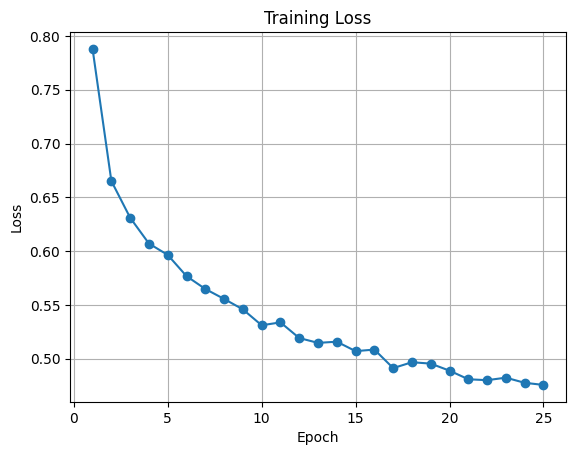

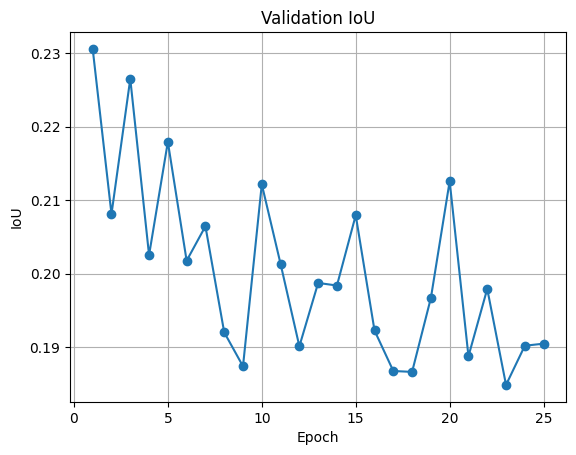

Done. Last epoch: 25 val IoU: 0.19047642136324477


In [15]:
model = ABCB(
    dim=256,
    T=3,
    pretrained_backbone=True,
    num_heads=4,
    L_hist=16,
    max_support_tokens=1024,
    max_fg_tokens=512,
    max_bg_tokens=512,
)

logs = train_abcb(
    model=model,
    train_ds=train_ds,
    val_ds=val_ds,
    device="cuda",         
    epochs=25,
    batch_size=16,
    base_lr=2e-3,
    momentum=0.9,
    weight_decay=1e-4,
    lam=0.2,
    crop_size=473,
    num_workers=4,
    save_dir="./runs/abcb"  
)

print("Done. Last epoch:", logs["epochs"][-1], "val IoU:", logs["val_ious"][-1])

In [16]:
train_ds[0][1].size()

torch.Size([1, 1, 473, 473])